In [ ]:
# IMPORTS

from arch import arch_model
from datetime import datetime, timedelta
from prophet import add_change_points_to_plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

# import facebook prophet
from prophet import Prophet

In [55]:
im_df = pd.read_excel("../raw_data/monthly_data_1mw_2mwh_bess_full_only_imbalance.xlsx").T

# keep columns 8 9 and 10
im_df = im_df.iloc[:, 8:11]
im_df

# rename columns
im_df.columns = ["imbalance_short", "imbalance_surp", "imbalance_total"]

# remove first row
im_df = im_df.iloc[1:]

# pass Jan/2021 to datetime
im_df.index = pd.date_range(start="2021-01-01", periods=len(im_df), freq="ME")

#set index name to Date
im_df.index.name = "Date"

im_df.to_csv("../processed_data/monthly_imbalance_only.csv")

11:37:51 - cmdstanpy - INFO - Chain [1] start processing


            imbalance_total
Date                       
2021-02-28         9678.224
2021-03-31        12221.497
2021-04-30         9082.683
2021-05-31        13223.984
2021-06-30        13695.495


11:37:52 - cmdstanpy - INFO - Chain [1] done processing


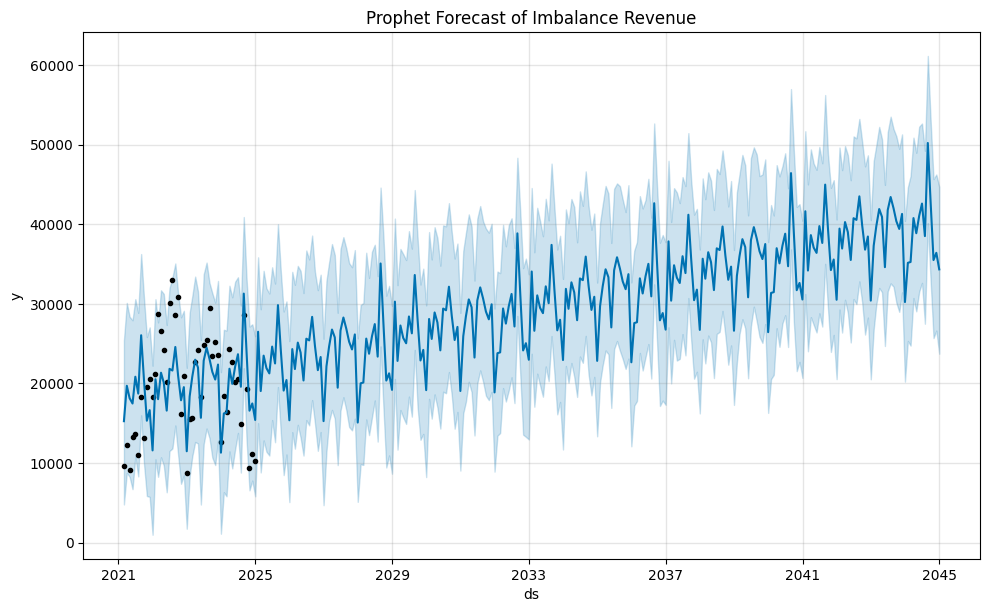

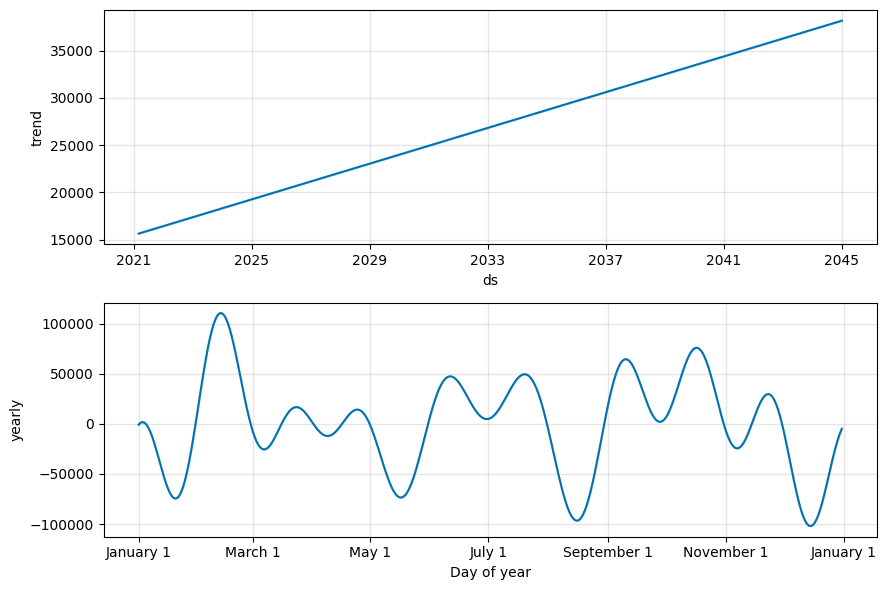

In [68]:
# Load your data
df = pd.read_csv("../processed_data/monthly_imbalance_only.csv", parse_dates=["Date"])[["imbalance_total", "Date"]]
df['Date'] = pd.to_datetime(df['Date'])

# Set the date as index
df.set_index('Date', inplace=True)

# delete first month
df = df.iloc[1:]

print(df.head())

# Prepare for Prophet
prophet_df = df.reset_index()
prophet_df.columns = ['ds', 'y']

# Initialize and fit the model
model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False, interval_width=0.95)
model.fit(prophet_df)

# Forecast 365 days ahead
future = model.make_future_dataframe(periods=12*20, freq='ME')
forecast_im = model.predict(future)

# Plot forecast
model.plot(forecast_im, uncertainty=True)
plt.title('Prophet Forecast of Imbalance Revenue')
plt.show()

# Plot components
model.plot_components(forecast_im)
plt.show()


09:54:30 - cmdstanpy - INFO - Chain [1] start processing
09:54:30 - cmdstanpy - INFO - Chain [1] done processing


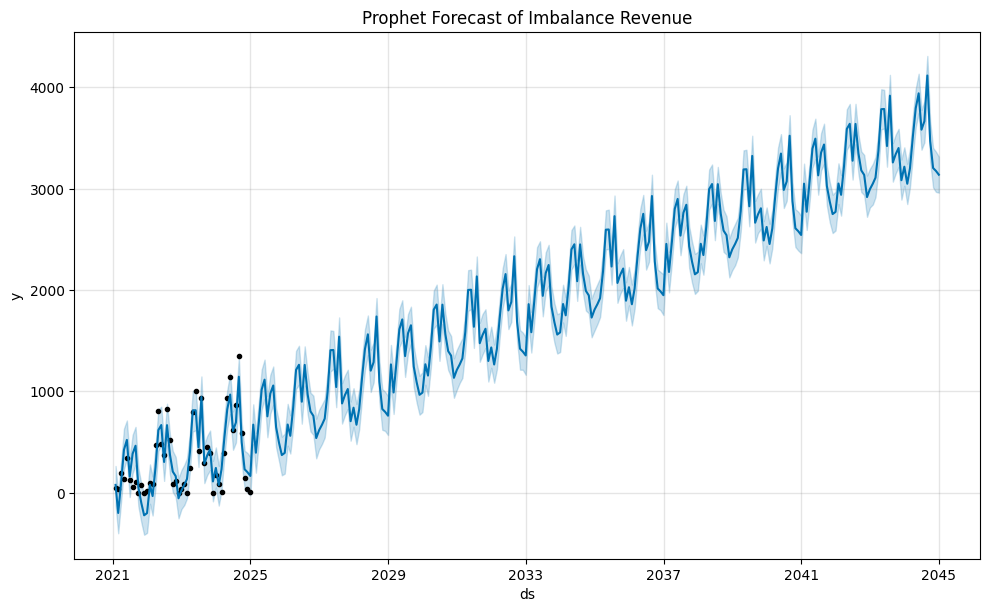

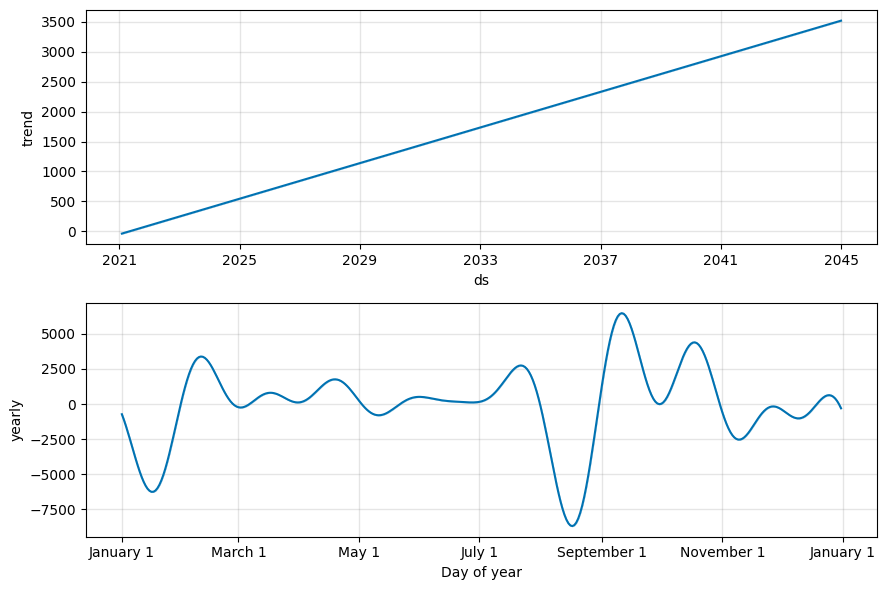

In [16]:
# Load your data
df = pd.read_csv("../processed_data/historical_data.csv", parse_dates=["Date"])
df['Date'] = pd.to_datetime(df['Date'])
# Set the date as index
df.set_index('Date', inplace=True)

df = df["Day-ahead Only"]

# Prepare for Prophet
prophet_df = df.reset_index()
prophet_df.columns = ['ds', 'y']

# Initialize and fit the model
model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
model.fit(prophet_df)

# Forecast 365 days ahead
future = model.make_future_dataframe(periods=12*20, freq='ME')
forecast_da = model.predict(future)

# Plot forecast
model.plot(forecast_da)
plt.title('Prophet Forecast of Imbalance Revenue')
plt.show()

# Plot components
model.plot_components(forecast_da)
plt.show()


          ds         trend   yhat_lower    yhat_upper   trend_lower  \
0 2021-01-31  18377.502680  7233.066649  34585.749065  18377.502680   
1 2021-02-28  18363.940103  4216.072776  31183.820349  18363.940103   
2 2021-03-31  18348.924394   -53.983542  26167.484869  18348.924394   
3 2021-04-30  18334.393063  7889.784442  34480.758991  18334.393063   
4 2021-05-31  18319.377359  8010.829781  33774.814545  18319.377359   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  18377.502680     2587.252066           2587.252066           2587.252066   
1  18363.940103     -537.345063           -537.345063           -537.345063   
2  18348.924394    -5544.789769          -5544.789769          -5544.789769   
3  18334.393063     2456.429949           2456.429949           2456.429949   
4  18319.377359     2739.503431           2739.503431           2739.503431   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  2587.252066   2587.252066  

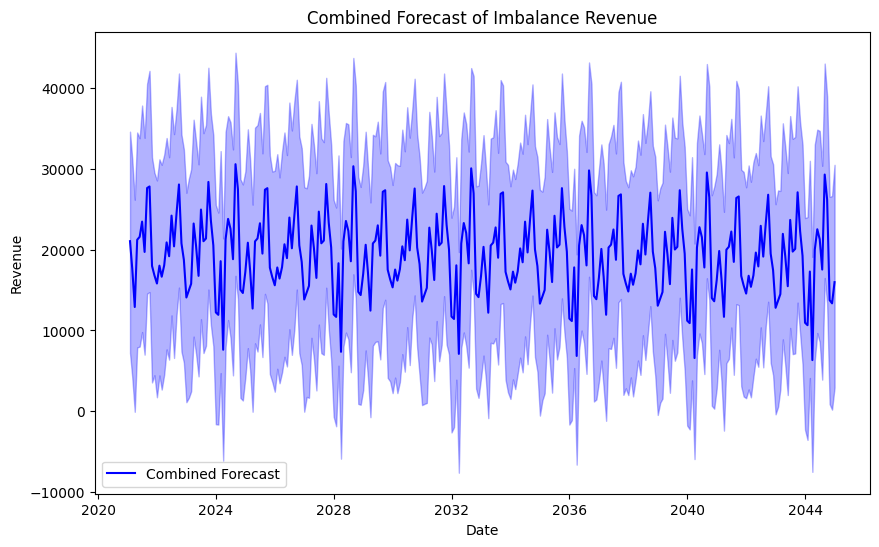

In [35]:
# Add the two forecasts together
forecast_combined = forecast_im.copy()
forecast_combined['yhat'] += forecast_da['yhat']
forecast_combined['yhat_lower'] += forecast_da['yhat_lower']
forecast_combined['yhat_upper'] += forecast_da['yhat_upper']

print(forecast_combined.head())

# Plot the combined forecast
plt.figure(figsize=(10, 6))
plt.plot(forecast_combined['ds'], forecast_combined['yhat'], label='Combined Forecast', color='blue')
plt.fill_between(forecast_combined['ds'], forecast_combined['yhat_lower'], forecast_combined['yhat_upper'], color='blue', alpha=0.3)
plt.title('Combined Forecast of Imbalance Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()


# Hour of Day Mean-Variance Sampling (Laplace)

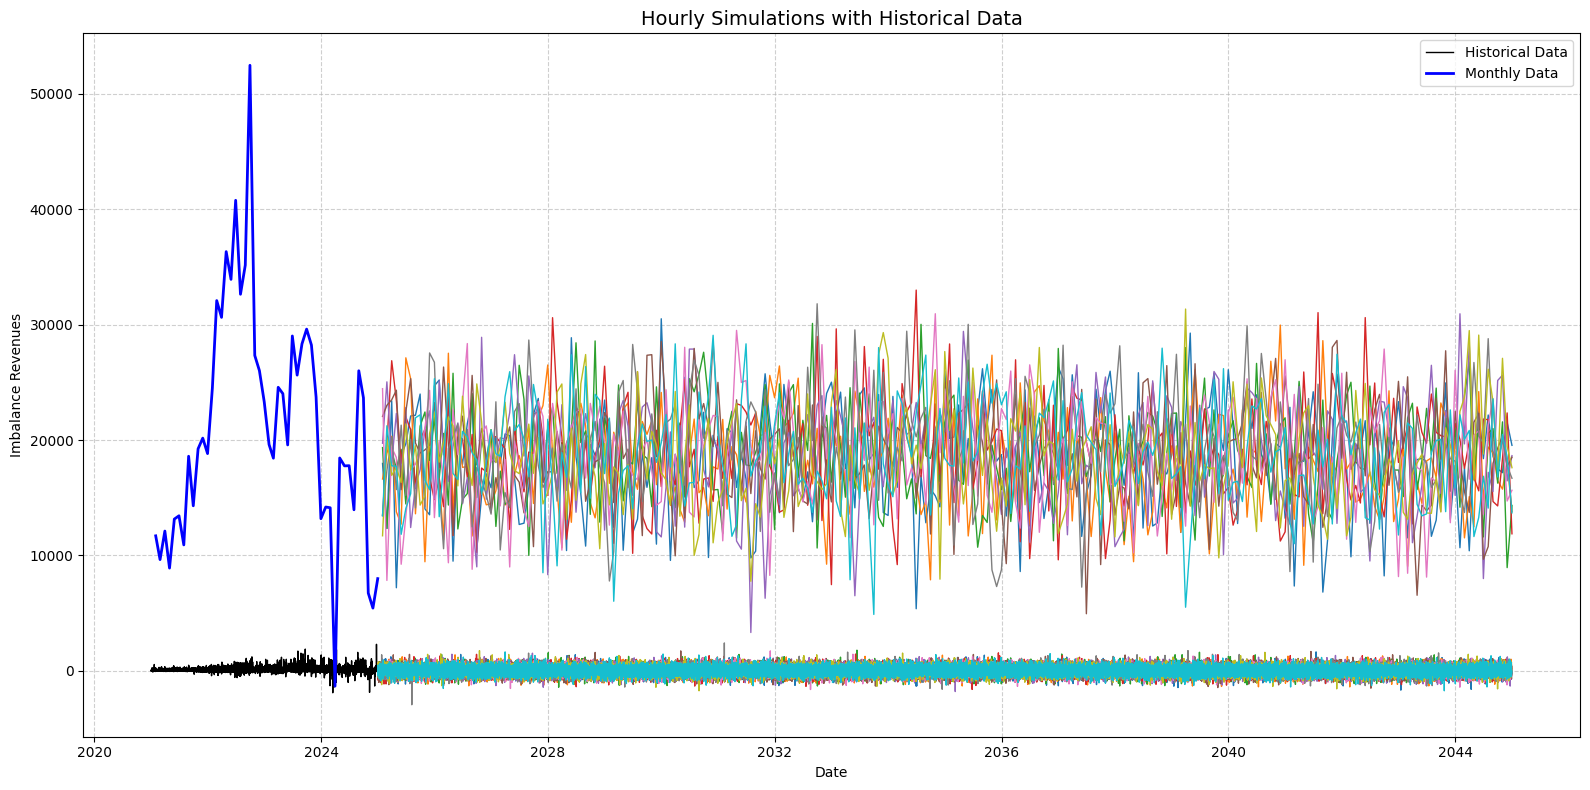

In [45]:
hourly_data = pd.read_csv("../processed_data/imbalance_revenue_hourly.csv", parse_dates=["Date"])
hourly_data.set_index("Date", inplace=True)
hourly_data["Hour"] = hourly_data.index.hour

# plot histogram of imbalance revenues
# plt.figure(figsize=(20, 10))
# plt.hist(hourly_data["imbalance"], bins=1000, color='blue', alpha=0.7)
# plt.title("Histogram of Imbalance Revenues")

# use only after 2022-12-31
hourly_data_reduced = hourly_data[hourly_data.index > "2022-12-31"]

# Compute hourly statistics
hourly_stats = hourly_data_reduced.groupby('Hour')['imbalance'].agg(['mean', 'std'])

# Simulation settings
num_simulations = 10
forecast_days = 20 * 365

simulations = {}

# Efficient simulation generation
for i in range(num_simulations):
    np.random.seed(20 + i)
    # Create DataFrame for 24 hours × forecast_days
    random_values = np.array([
        np.random.laplace(loc=hourly_stats.loc[hour, "mean"],
                         scale=hourly_stats.loc[hour, "std"],
                         size=forecast_days)
        for hour in range(24)
    ])
    
    # Build DataFrame
    columns = [f"day_{day}" for day in range(forecast_days)]
    random_samples = pd.DataFrame(random_values, index=range(24), columns=columns)
    random_samples.index.name = "hour"

    # Store in simulations dictionary
    simulations[f"simulation_{i}"] = random_samples

# Plotting
plt.figure(figsize=(16, 8))
monthly_data = hourly_data.resample("ME").sum()

plt.plot(hourly_data.index, hourly_data["imbalance"], label="Historical Data", color="black", linewidth=1)
plt.plot(monthly_data.index, monthly_data["imbalance"], label="Monthly Data", color="blue", linewidth=2)

# Simulation plotting
start_date = hourly_data.index[-1] + pd.Timedelta(hours=24)
simulation_dates = pd.date_range(start=start_date, periods = 24 * forecast_days, freq='h')

sim_colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']

# create a dataframe of the size of the forecast_days at an hourly frequency
simulated_data = pd.DataFrame()

for i, (sim_name, sim_data) in enumerate(simulations.items()):
    simulated_data[sim_name] = sim_data.T.values.flatten()

simulated_data = simulated_data
simulated_data.index = simulation_dates

plt.plot(simulated_data.index, simulated_data.values, alpha=1, linewidth=1)

# Monthly aggregation of the forecast
monthly_forecast = simulated_data.resample("ME").sum()
plt.plot(monthly_forecast.index, monthly_forecast.values, alpha=1, linewidth=1)

# Finalize plot
plt.title("Hourly Simulations with Historical Data", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Imbalance Revenues")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="best")
plt.tight_layout()
plt.show()


# SARIMAX

## Outlier Importance and structure

In [ ]:
hourly_data = pd.read_csv("../processed_data/imbalance_revenue_hourly.csv", parse_dates=["Date"])
hourly_data.set_index("Date", inplace=True)
hourly_data["Hour"] = hourly_data.index.hour

# Extract date components
hourly_data['date'] = hourly_data.index.date

# Pivot the data to get hours as columns and days as rows
hourly_pivot = hourly_data.pivot(index='date', columns='Hour', values='imbalance')
hourly_pivot.columns = [f'Hour_{col}' for col in hourly_pivot.columns]
hourly_pivot.dropna(inplace=True)
hourly_pivot.index = pd.to_datetime(hourly_pivot.index)

yearly_dict = {}
for i in range(1, 5):
    yearly_dict[i] = hourly_pivot[hourly_pivot.index.year == 2020 + i]

# calculate the value of the outliers per year
for i in range(1, 5):
    yearly_data = yearly_dict[i]
    z = stats.zscore(yearly_data, axis=0)

    # count how many outliers are in the data
    outliers = np.sum(np.abs(z) > 3, axis=0)
    print(f"Number of outliers in year {2020 + i}: {outliers}")

    # count the value of the outliers
    outlier_values = yearly_data.values[np.abs(z) > 3]
    all_values = yearly_data.values
    all_values_sum = all_values.sum()
    sum_outlier_values = outlier_values.sum()
    print(f"Sum of all values in year {2020 + i}: {all_values_sum}")
    print(f"Sum of outlier values in year {2020 + i}: {sum_outlier_values}")
    print(f"Percentage of outlier values in year {2020 + i}: {sum_outlier_values / all_values_sum * 100:.2f}%")

Number of outliers in year 2021: [11  8 10 10 10 10  8 12  9  6  7  9  9 13 10  9  7 13  8  9  5 10  9 10]
Sum of all values in year 2021: 171032.304926716
Sum of outlier values in year 2021: 47426.633507742
Percentage of outlier values in year 2021: 27.73%
Number of outliers in year 2022: [ 7  8  7  8  8  6 10  8  6  6  7 10 14 11  8  6  7  8  8  8  9  7  8  5]
Sum of all values in year 2022: 395215.54584030504
Sum of outlier values in year 2022: 76094.794474828
Percentage of outlier values in year 2022: 19.25%
Number of outliers in year 2023: [11  5  8  6  5  7  9 11 12  8  8  6  8  9 12  9 13  8 13  6  8  7  8  8]
Sum of all values in year 2023: 283989.64356288296
Sum of outlier values in year 2023: 107828.314146664
Percentage of outlier values in year 2023: 37.97%
Number of outliers in year 2024: [ 7  9  4  9  9  7  6 12 10  5  8 15 11  9  8  8  9  9  7  5 10  9  5  6]
Sum of all values in year 2024: 164447.31530859
Sum of outlier values in year 2024: 59692.94476324599
Percentage o

## Volatility Modelling

              Hour_0     Hour_1     Hour_2     Hour_3     Hour_4     Hour_5  \
date                                                                          
2021-01-02  4.179167  -0.192333  -3.750000  -1.824667   4.215000   3.584333   
2021-01-03 -4.984000   0.619500  28.846500   3.930833   4.342000   6.656500   
2021-01-04 -0.748833  -1.409667   3.261280   0.000000   0.000000   0.298000   
2021-01-05  3.212167  -2.085000  -1.368667   0.365333   6.404657   8.138000   
2021-01-06  6.100167  12.436500  -2.223333  36.443333  25.327333  15.062559   

               Hour_6      Hour_7      Hour_8     Hour_9  ...    Hour_14  \
date                                                      ...              
2021-01-02   0.346500   15.826431   -4.967820  -4.699744  ...  -6.083188   
2021-01-03  -3.660000    4.210167   64.987833  96.951289  ...   4.357000   
2021-01-04  26.259667   55.390333  -22.271000  -5.181167  ...   8.102833   
2021-01-05  24.907000  219.676333  217.962500  -4.038637  ...  -8.

c:\Users\ArnauDuatisTarradell\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\ArnauDuatisTarradell\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


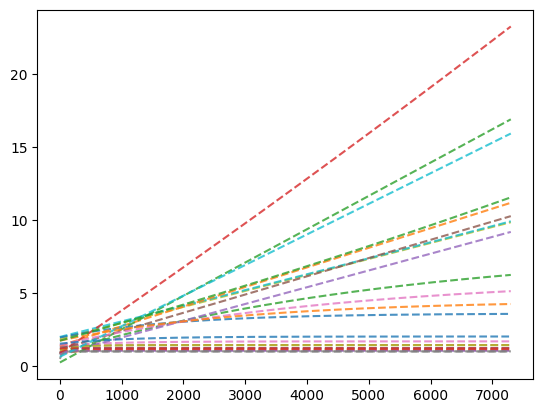

In [ ]:
hourly_data = pd.read_csv("../processed_data/imbalance_revenue_hourly.csv", parse_dates=["Date"])
hourly_data.set_index("Date", inplace=True)
hourly_data["Hour"] = hourly_data.index.hour

# Extract date components
hourly_data['date'] = hourly_data.index.date

# Pivot the data to get hours as columns and days as rows
hourly_pivot = hourly_data.pivot(index='date', columns='Hour', values='imbalance')
hourly_pivot.columns = [f'Hour_{col}' for col in hourly_pivot.columns]
hourly_pivot.dropna(inplace=True)
hourly_pivot.index = pd.to_datetime(hourly_pivot.index)

print(hourly_pivot.head())

for i, column in enumerate(hourly_pivot.columns):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(hourly_pivot[column].values.reshape(-1, 1))

    # Make volatility predictions using GARCH model
    model = arch_model(scaled_data, vol='Garch', p=1, q=1)
    model_fit = model.fit(disp="off")
    forecast = model_fit.forecast(horizon=365 * 20)
    
    plt.plot(forecast.variance.values[-1, :], label=f"Forecast Hour {i}", linestyle='--', alpha=0.8)
    

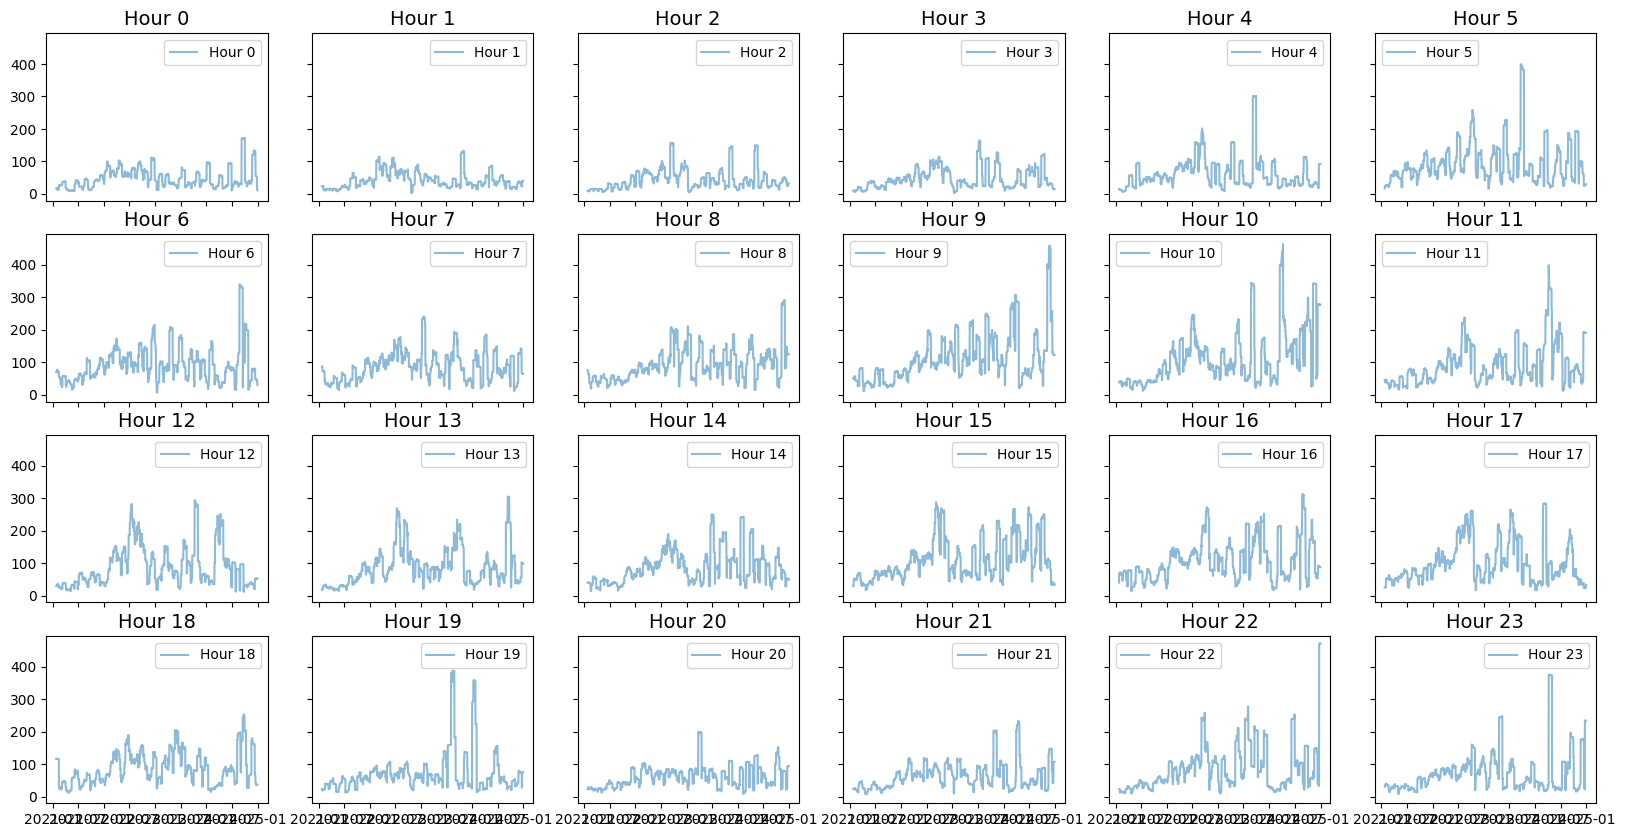

In [ ]:
fig, ax = plt.subplots(4, 6, figsize=(20, 10), sharex=True, sharey=True)

for i, column in enumerate(hourly_pivot.columns):
    ax[i // 6, i % 6].plot(hourly_pivot[column].rolling(window=24).std(), label=f"Hour {i}", alpha=0.5)
    ax[i // 6, i % 6].set_title(f"Hour {i}", fontsize=14)
    ax[i // 6, i % 6].legend()

In [ ]:
for column in hourly_pivot.columns:
    train, test = hourly_pivot[column].iloc[:-300], hourly_pivot[column].iloc[-300:]
    

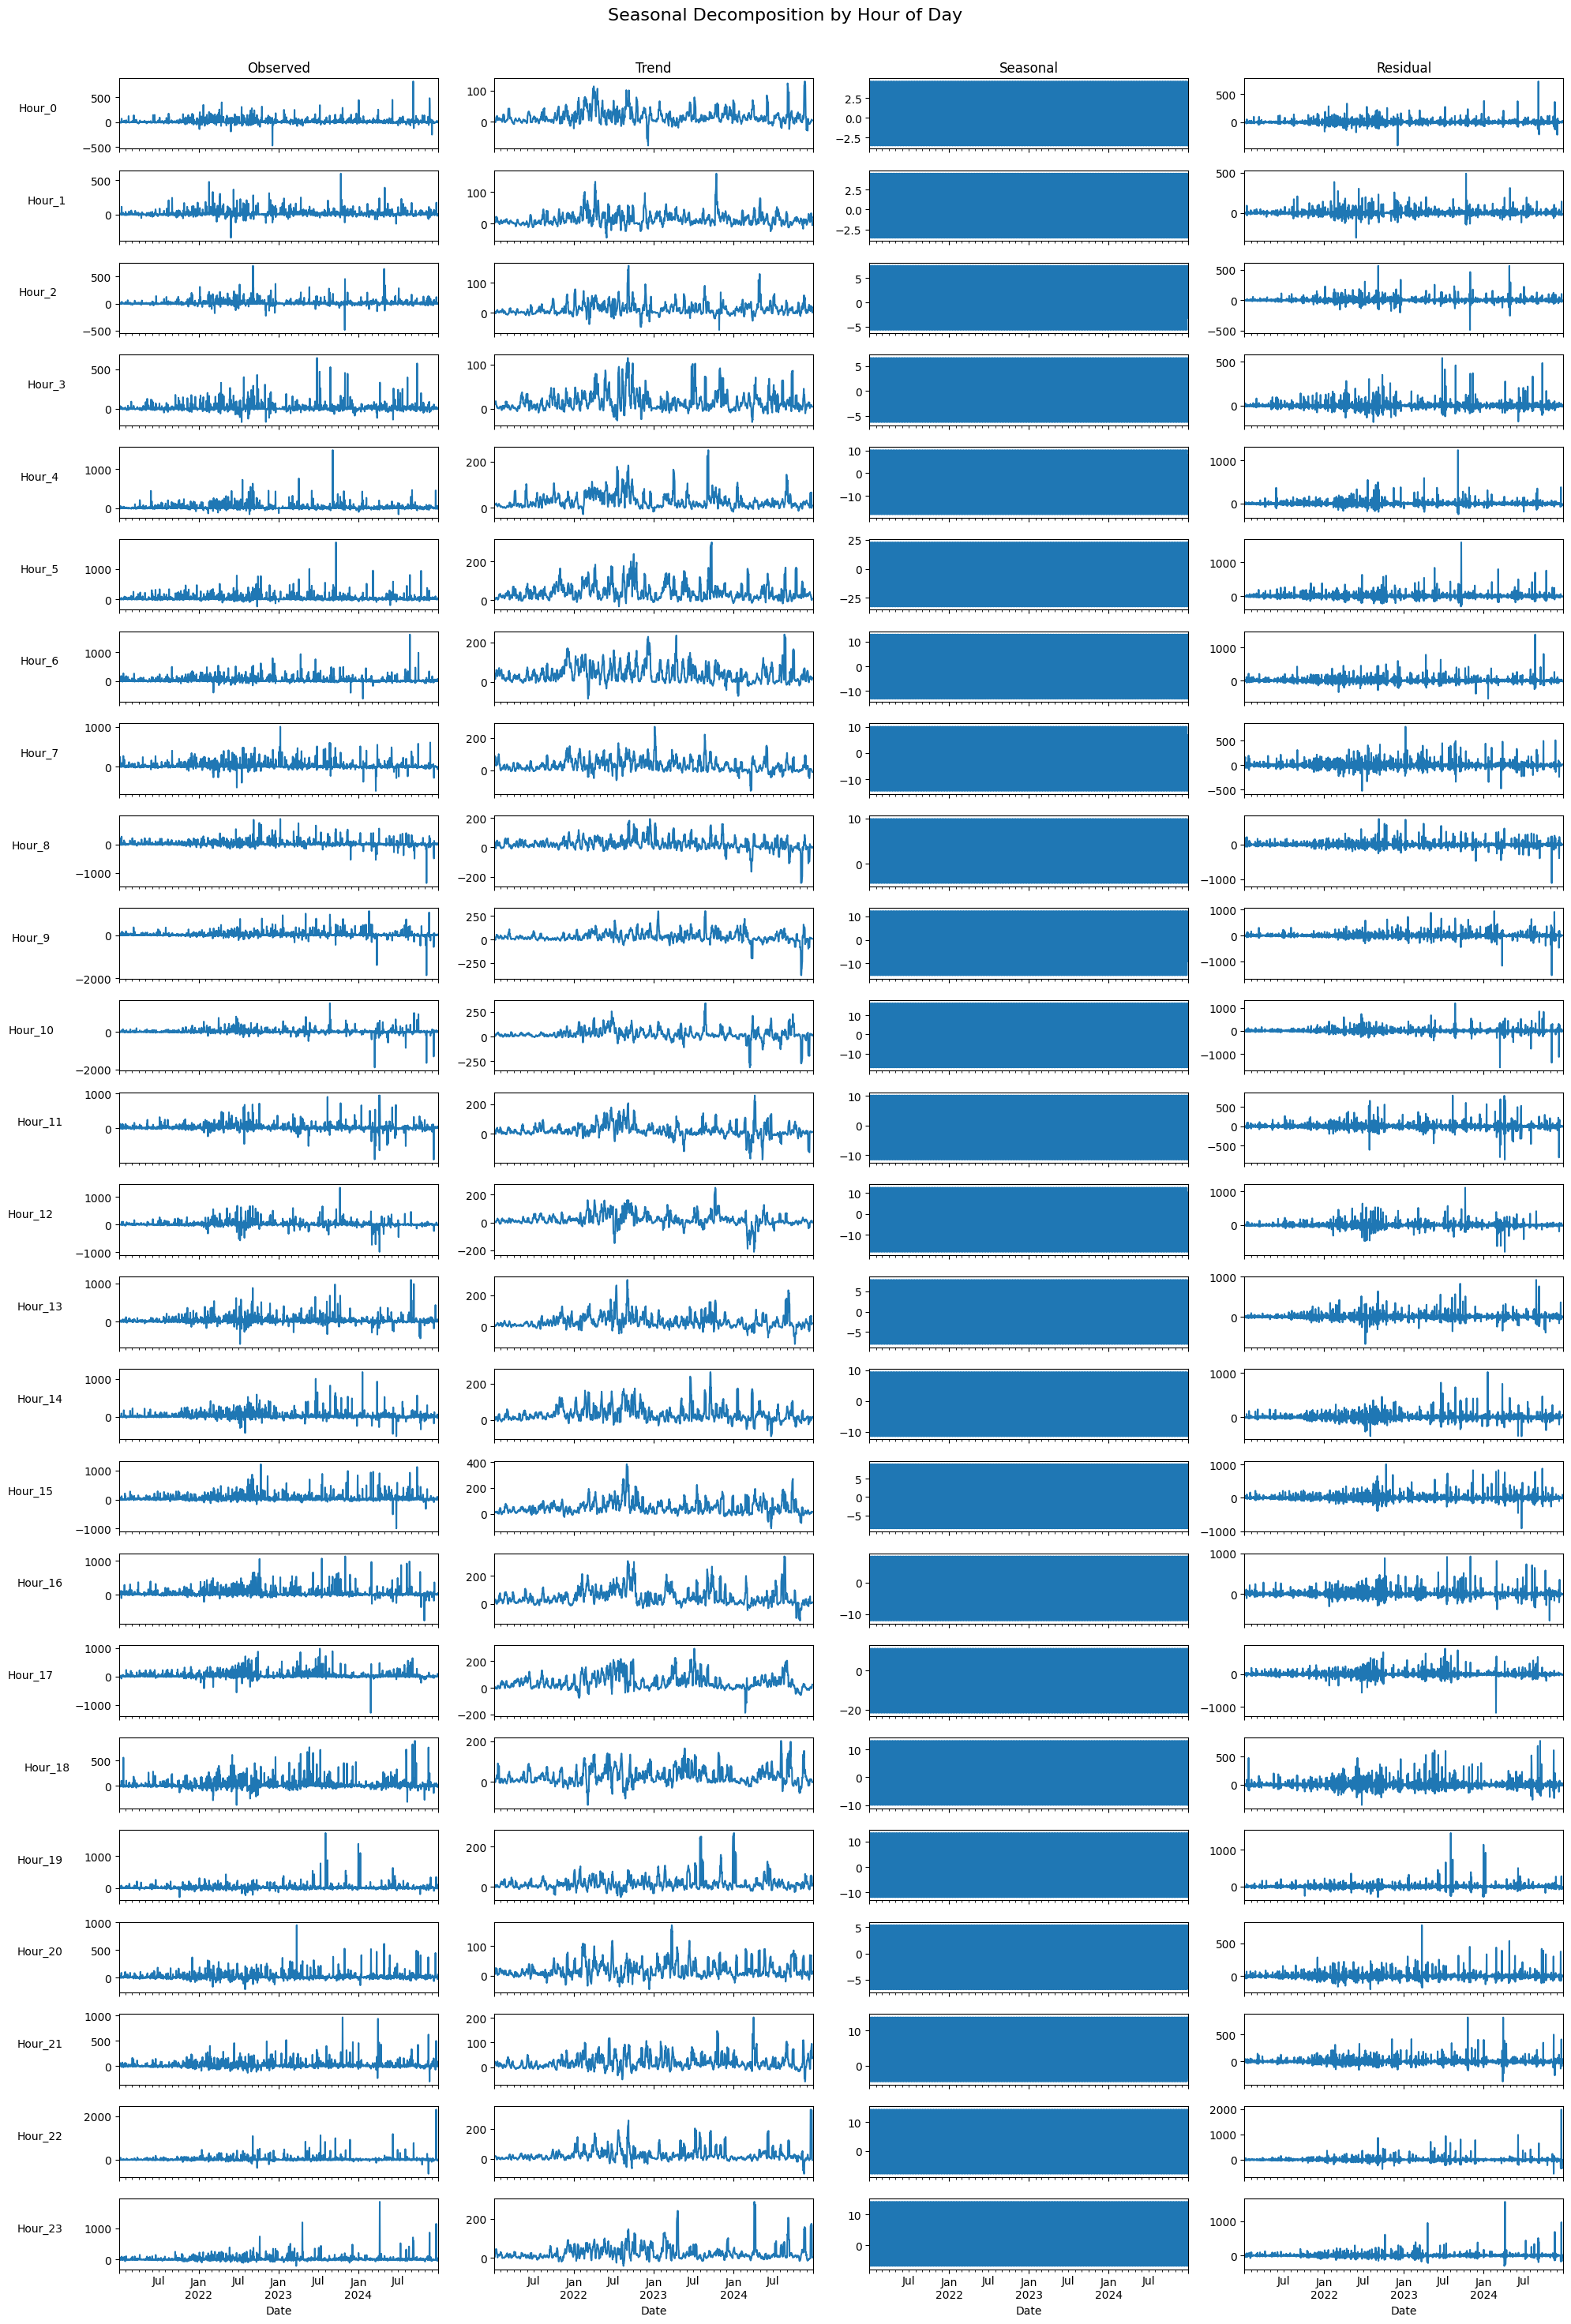

In [ ]:
# Seasonal decomposition for each hour of the day
fig, axes = plt.subplots(24, 4, figsize=(20, 30), sharex=True)
fig.suptitle('Seasonal Decomposition by Hour of Day', fontsize=16)

# Extract seasonal component for each hour
for i, column in enumerate(hourly_pivot.columns):
    # Get results of seasonal decomposition
    result = seasonal_decompose(hourly_pivot[column], model='additive', period=7)  # Using weekly seasonality
    
    # Plot in the appropriate row
    result.observed.plot(ax=axes[i, 0], legend=False)
    result.trend.plot(ax=axes[i, 1], legend=False)
    result.seasonal.plot(ax=axes[i, 2], legend=False)
    result.resid.plot(ax=axes[i, 3], legend=False)
    
    # Set row titles
    axes[i, 0].set_ylabel(column, rotation=0, labelpad=40, fontsize=10)
    
    # Only set x-label for bottom row
    if i == 23:
        axes[i, 0].set_xlabel('Date')
        axes[i, 1].set_xlabel('Date')
        axes[i, 2].set_xlabel('Date')
        axes[i, 3].set_xlabel('Date')

# Set column titles (only for the top row)
axes[0, 0].set_title('Observed')
axes[0, 1].set_title('Trend')
axes[0, 2].set_title('Seasonal')
axes[0, 3].set_title('Residual')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Make room for the suptitle
plt.show()

# plt.figure(figsize=(16, 8))
# for column in hourly_pivot.columns:
#     plt.plot(hourly_pivot.index, hourly_pivot[column], label=column, alpha=0.5)
# plt.title("Hourly Imbalance Revenue Data", fontsize=14)
# plt.legend(loc="upper left")
# plt.show()

# train, test = hourly_pivot.iloc[:-int(0.2*len(hourly_pivot))], hourly_pivot.iloc[-int(0.2*len(hourly_pivot)):]

# mse_list = []

# for column in train.columns:
#     for p in range(1, 4):
#         for d in range(0, 2):
#             for q in range(1, 4):
#                     # Fit ARIMA model
#                     print(f"Fitting ARIMA({p}, {d}, {q}) for {column}")
#                     model = ARIMA(train[column], seasonal_order = (p, d, q, ?) order = (p, d, q))
#                     model_fit = model.fit()
#                     # test the model on the test set
#                     predictions = model_fit.forecast(steps=len(test))
#                     mse = ((predictions - test[column]) ** 2).mean()
#                     mse_list.append((column, p, d, q, mse))

## GARCH Simulations - TEST

In [ ]:
# Load and prepare data
hourly_data = pd.read_csv("../processed_data/imbalance_revenue_hourly.csv", parse_dates=["Date"])
hourly_data.set_index("Date", inplace=True)
hourly_data["Hour"] = hourly_data.index.hour

# Simulation settings
num_simulations = 1
forecast_days = 365
np.random.seed(14)

# Fit a GARCH(1,1) model for each hour
garch_models = {}
for hour in range(24):
    series = hourly_data[hourly_data["Hour"] == hour]["imbalance"]
    series = series - series.mean()
    model = arch_model(series, vol="Garch", p=1, q=1)
    fit_result = model.fit(disp="off")
    garch_models[hour] = {"model": model, "fit_result": fit_result}

# Simulate forecast_days of data per hour
simulations = {}
for i in range(num_simulations):
    sim_data = []
    for hour in range(24):
        sim = garch_models[hour]["model"].simulate(
            garch_models[hour]["fit_result"].params,
            nobs=forecast_days
)
        sim_data.append(sim['data'].values)

    sim_matrix = np.array(sim_data)
    sim_df = pd.DataFrame(sim_matrix, index=range(24), columns=[f"day_{d}" for d in range(forecast_days)])
    sim_df.index.name = "hour"
    simulations[f"simulation_{i}"] = sim_df

# Plotting
plt.figure(figsize=(16, 8))
# Plot last 2 months of historical data (48 days × 24 hours)
last_2months = hourly_data.iloc[-24*60:]
plt.plot(last_2months.index, last_2months["imbalance"], label="Historical Data", color="black", linewidth=2)

# Simulated future time range
start_date = hourly_data.index[-1] + pd.Timedelta(hours=1)
simulation_dates = pd.date_range(start=start_date, periods=24 * forecast_days, freq='h')

sim_colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']

# Plot each simulation
for i, (sim_key, sim_df) in enumerate(simulations.items()):
    flat_sim = sim_df.values.flatten()
    sim_series = pd.Series(flat_sim, index=simulation_dates)
    plt.plot(sim_series.index, sim_series, label=f"GARCH Simulation {i+1}", color=sim_colors[i % len(sim_colors)], linewidth=1.5)

    # Monthly aggregation of the forecast
    monthly_forecast = sim_series.resample("M").sum()
    monthly_forecast.plot(kind="line", color="steelblue")

plt.title("Hourly GARCH Simulations with Historical Data", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Hourly Imbalance Revenue")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="best")
plt.tight_layout()
plt.show()
